# Learn To Synchronize Videos

## Model declaration

In [1]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sync_net
import trainer
import metrics
import data_loader
reload(sync_net)
reload(trainer)
reload(metrics)
reload(data_loader)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, TripletNet, MultiSiameseNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss, MultiSiameseCosineSimilarityLoss, SoftMultiSiameseCosineSimilarityLoss
from data_loader import get_datasets, get_test_set, get_multisiamese_datasets, get_soft_multisiamese_datasets
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric
# import wandb
# wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.resnet50(pretrained=True)
reset_first_layer(embedding_net)
replace_last_layer(embedding_net, 4)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
# model = TripletNet(embedding_net)
model = MultiSiameseNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
loss_fn = MultiSiameseCosineSimilarityLoss()
# loss_fn = SoftMultiSiameseCosineSimilarityLoss()
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\multisiamese_pos1"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
# wandb.config.lr = lr
# wandb.config.optimizer = type(optimizer)
# wandb.config.loss_fn = type(loss_fn)

## Load dataset

### Angio sequence triplets

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

### Angio sequence multi siamese

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_multisiamese_datasets(training_path, validation_path, 1000, 64)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

### Angio sequence soft multi siamese

In [6]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_soft_multisiamese_datasets(training_path, validation_path, 1000, 64)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

### Load MNIST dataset instead

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(r"C:\Users\root\Data\MNIST", train=True, download=True, transform=transformations)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.mnist_dataset)
    
    
triplet_mnist = TripletMNIST(mnist_trainset)
train_loader = DataLoader(triplet_mnist, batch_size=20, shuffle=True, num_workers=0)
# for batch_index, triplet in enumerate(train_loader):
#     for i, image in enumerate(triplet):
#         print(f"batch {batch_index}, i {i}, triplet {image.numpy().shape}")
#         plt.subplot(1, 3, i+1)
#         plt.imshow(image.view(224, 224).numpy())
#         plt.title("Anchor" if i == 0 else "Positive" if i == 1 else "Negative")
#     plt.show()
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, None, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

## Load training state

In [ ]:
load_state_path = save_path + r"\training_state_0.pth"
print(load_state_path)
state = torch.load(load_state_path)

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [ ]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

### Angio sequence triplets

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

### Angio sequence multisiamese

Starting Epoch 0
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 1.363083	Elapsed time: 0:00:43.267680	FCWeights (Diff, Avg, Total): (0.7812554836273193, 0.028095483779907227, 230.158203125)
Train: [7400/1000 (20%)]	Loss: 1.313450	Elapsed time: 0:01:25.168467	FCWeights (Diff, Avg, Total): (1.3962236642837524, 0.028779324144124985, 235.76022338867188)
Train: [12900/1000 (30%)]	Loss: 1.301982	Elapsed time: 0:02:06.877334	FCWeights (Diff, Avg, Total): (0.6133006811141968, 0.029153918847441673, 238.8289031982422)
Train: [25600/1000 (40%)]	Loss: 1.126917	Elapsed time: 0:02:50.199539	FCWeights (Diff, Avg, Total): (1.4455037117004395, 0.029423456639051437, 241.03695678710938)
Train: [19500/1000 (50%)]	Loss: 1.111090	Elapsed time: 0:03:30.893585	FCWeights (Diff, Avg, Total): (0.784032940864563, 0.029918832704424858, 245.09507751464844)
Train: [26400/1000 (60%)]	Loss: 1.125681	Elapsed time: 0:04:14.044844	FCWeights (Diff, Avg, Total): (0.6806463003158569, 0.03038429282605648, 248.9

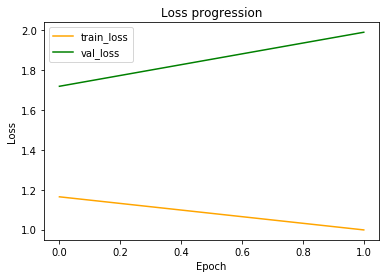

Starting Epoch 2
Will sample from train_loader
Train: [4900/1000 (10%)]	Loss: 0.933886	Elapsed time: 0:00:42.090208	FCWeights (Diff, Avg, Total): (0.7042791247367859, 0.03903839364647865, 319.8025207519531)
Train: [8800/1000 (20%)]	Loss: 0.943875	Elapsed time: 0:01:23.963989	FCWeights (Diff, Avg, Total): (0.41084784269332886, 0.03917887806892395, 320.953369140625)
Train: [14700/1000 (30%)]	Loss: 0.923856	Elapsed time: 0:02:05.400789	FCWeights (Diff, Avg, Total): (0.22067555785179138, 0.04001825302839279, 327.82952880859375)
Train: [25600/1000 (40%)]	Loss: 0.988636	Elapsed time: 0:02:47.400714	FCWeights (Diff, Avg, Total): (1.4670790433883667, 0.04123181849718094, 337.77105712890625)
Train: [32000/1000 (50%)]	Loss: 0.985865	Elapsed time: 0:03:29.093456	FCWeights (Diff, Avg, Total): (1.4977130889892578, 0.04197622835636139, 343.8692626953125)
Train: [17400/1000 (60%)]	Loss: 1.039005	Elapsed time: 0:04:11.573306	FCWeights (Diff, Avg, Total): (0.396531343460083, 0.04250944405794144, 348.23

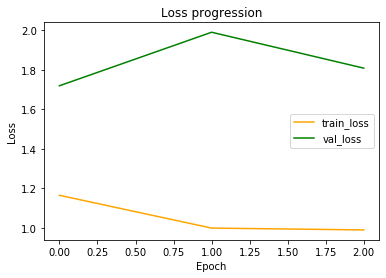

Starting Epoch 3
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.942137	Elapsed time: 0:00:42.791224	FCWeights (Diff, Avg, Total): (0.16650521755218506, 0.04487999156117439, 367.6568908691406)
Train: [12800/1000 (20%)]	Loss: 0.914968	Elapsed time: 0:01:25.942717	FCWeights (Diff, Avg, Total): (0.43765801191329956, 0.04501953721046448, 368.800048828125)
Train: [19200/1000 (30%)]	Loss: 0.887640	Elapsed time: 0:02:06.805449	FCWeights (Diff, Avg, Total): (0.7459633946418762, 0.045401185750961304, 371.926513671875)
Train: [18000/1000 (40%)]	Loss: 0.855544	Elapsed time: 0:02:48.011773	FCWeights (Diff, Avg, Total): (0.165402352809906, 0.045520178973674774, 372.90130615234375)
Train: [24500/1000 (50%)]	Loss: 0.903388	Elapsed time: 0:03:31.305152	FCWeights (Diff, Avg, Total): (0.1899728775024414, 0.04563687741756439, 373.8572998046875)
Train: [25200/1000 (60%)]	Loss: 0.904011	Elapsed time: 0:04:11.599369	FCWeights (Diff, Avg, Total): (0.1523509919643402, 0.04576714709401131, 374.9

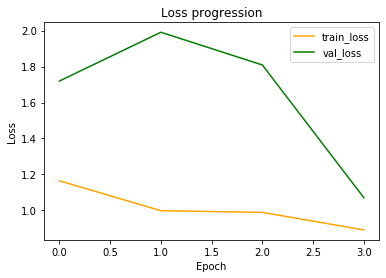

Starting Epoch 4
Will sample from train_loader
Train: [2900/1000 (10%)]	Loss: 0.929162	Elapsed time: 0:00:42.497081	FCWeights (Diff, Avg, Total): (0.145973339676857, 0.04676508158445358, 383.09954833984375)
Train: [8800/1000 (20%)]	Loss: 0.850839	Elapsed time: 0:01:23.988443	FCWeights (Diff, Avg, Total): (0.0516771599650383, 0.04674050211906433, 382.898193359375)
Train: [19200/1000 (30%)]	Loss: 0.895854	Elapsed time: 0:02:06.146653	FCWeights (Diff, Avg, Total): (0.017189286649227142, 0.04674457758665085, 382.93157958984375)
Train: [25600/1000 (40%)]	Loss: 0.911693	Elapsed time: 0:02:48.818073	FCWeights (Diff, Avg, Total): (0.0438181534409523, 0.04674061760306358, 382.8991394042969)
Train: [23000/1000 (50%)]	Loss: 0.899059	Elapsed time: 0:03:30.827571	FCWeights (Diff, Avg, Total): (0.06524993479251862, 0.04677179083228111, 383.1545104980469)
Train: [23400/1000 (60%)]	Loss: 0.878506	Elapsed time: 0:04:11.994827	FCWeights (Diff, Avg, Total): (0.07115140557289124, 0.046761851757764816, 383

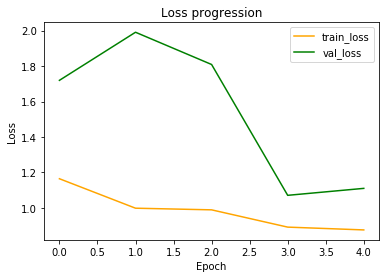

Starting Epoch 5
Will sample from train_loader
Train: [4700/1000 (10%)]	Loss: 0.844400	Elapsed time: 0:00:42.324685	FCWeights (Diff, Avg, Total): (0.0838707685470581, 0.046814773231744766, 383.5066223144531)
Train: [7800/1000 (20%)]	Loss: 0.863273	Elapsed time: 0:01:23.456363	FCWeights (Diff, Avg, Total): (0.029731016606092453, 0.046882085502147675, 384.05804443359375)
Train: [19200/1000 (30%)]	Loss: 0.907590	Elapsed time: 0:02:05.779897	FCWeights (Diff, Avg, Total): (0.1120266541838646, 0.04687622934579849, 384.01007080078125)
Train: [20000/1000 (40%)]	Loss: 0.848757	Elapsed time: 0:02:48.127615	FCWeights (Diff, Avg, Total): (0.07424134016036987, 0.046905361115932465, 384.24871826171875)
Train: [25000/1000 (50%)]	Loss: 0.844630	Elapsed time: 0:03:30.071455	FCWeights (Diff, Avg, Total): (0.01703178696334362, 0.04690015688538551, 384.2060852050781)
Train: [38400/1000 (60%)]	Loss: 0.852148	Elapsed time: 0:04:11.115026	FCWeights (Diff, Avg, Total): (0.11116379499435425, 0.0468861721456050

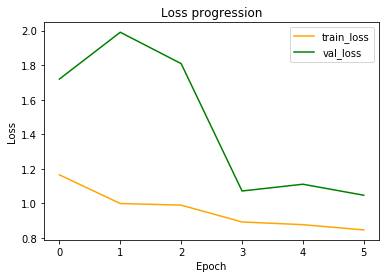

Starting Epoch 6
Will sample from train_loader
Train: [5200/1000 (10%)]	Loss: 0.799073	Elapsed time: 0:00:41.493996	FCWeights (Diff, Avg, Total): (0.017575178295373917, 0.0468796044588089, 384.0377197265625)
Train: [12800/1000 (20%)]	Loss: 0.829233	Elapsed time: 0:01:24.281828	FCWeights (Diff, Avg, Total): (0.1184735894203186, 0.04694419726729393, 384.5668640136719)
Train: [13500/1000 (30%)]	Loss: 0.828792	Elapsed time: 0:02:06.729543	FCWeights (Diff, Avg, Total): (0.077613465487957, 0.0469539612531662, 384.6468505859375)
Train: [16800/1000 (40%)]	Loss: 0.831981	Elapsed time: 0:02:48.292210	FCWeights (Diff, Avg, Total): (0.030119135975837708, 0.04692549630999565, 384.4136657714844)
Train: [25000/1000 (50%)]	Loss: 0.855076	Elapsed time: 0:03:30.462173	FCWeights (Diff, Avg, Total): (0.010875493288040161, 0.04693274945020676, 384.47308349609375)
Train: [25200/1000 (60%)]	Loss: 0.825641	Elapsed time: 0:04:12.396537	FCWeights (Diff, Avg, Total): (0.05615486204624176, 0.04697990417480469, 38

In [ ]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)
metrics = []  # [EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

## Test trained model

### Load model

In [2]:
load_state_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_4\training_state_8.pth"
print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_4\training_state_8.pth


DataParallel(
  (module): MultiSiameseNet(
    (embedding_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): 

### Load test set

In [3]:
test_path = r'C:\Users\root\Data\Angiographie'
test_set = get_test_set(test_path)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

### Compute distance and similarity matrices

Batch 1/56 (AA-4 LCA_30LAO25CAU) with 103 sequences


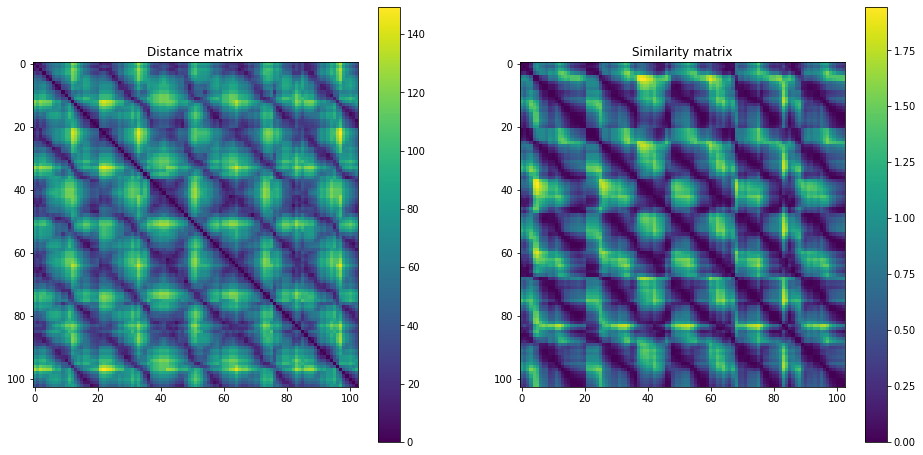

Batch 2/56 (AA-4 LCA_30RAO) with 108 sequences


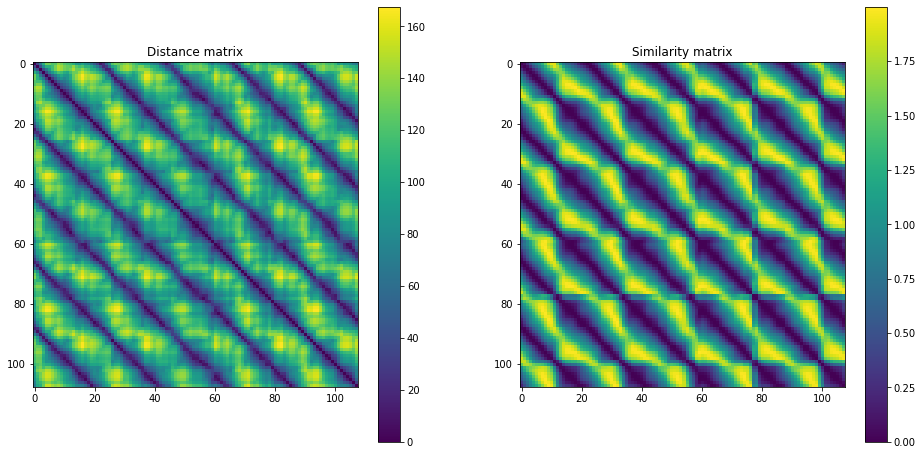

Batch 3/56 (AA-4 LCA_30RAO25CAU) with 102 sequences


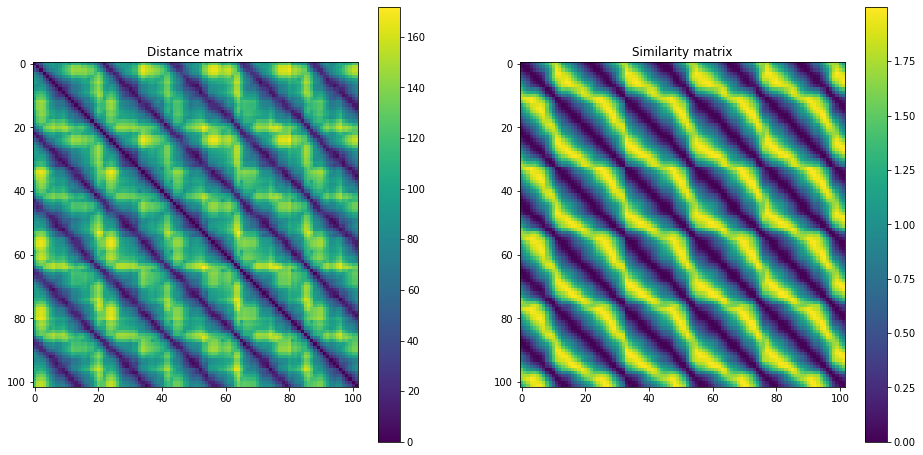

Batch 4/56 (AA-4 LCA_AP) with 76 sequences


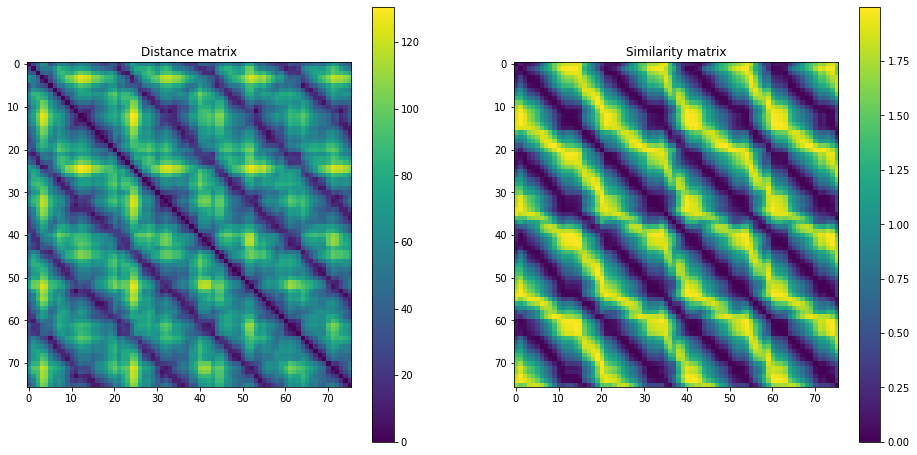

Batch 5/56 (AA-4 LCA_LAT) with 77 sequences


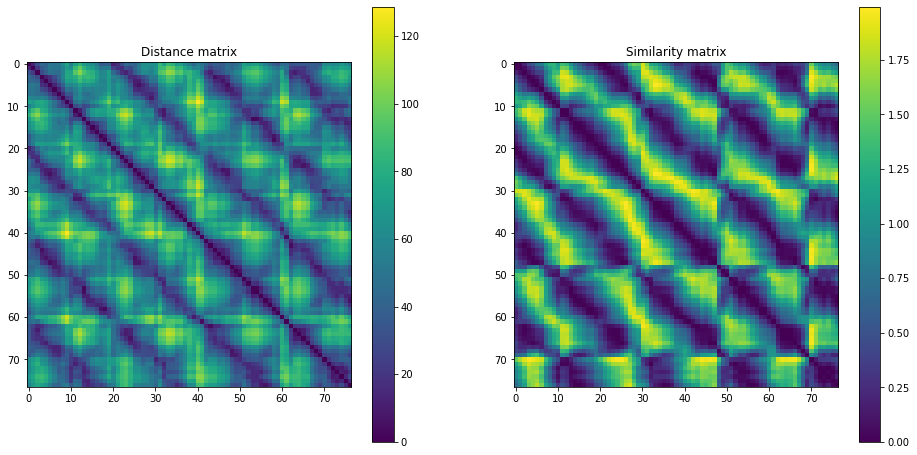

Batch 6/56 (AA-4 RCA_AP) with 119 sequences


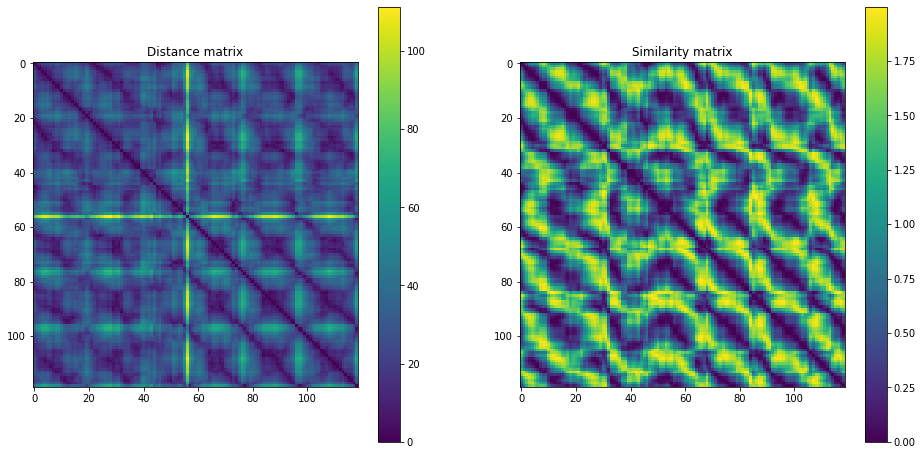

Batch 7/56 (AA-4 RCA_LAT) with 111 sequences


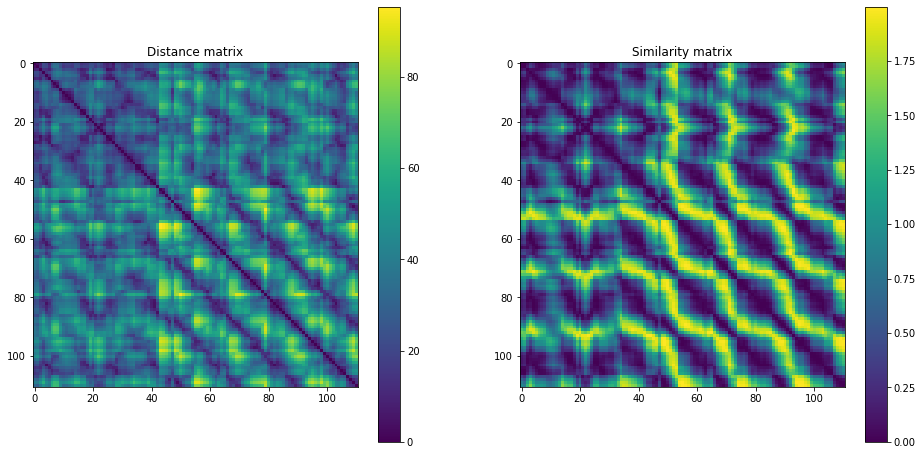

Batch 8/56 (ABL-5 LCA_30LAO25CRA) with 73 sequences


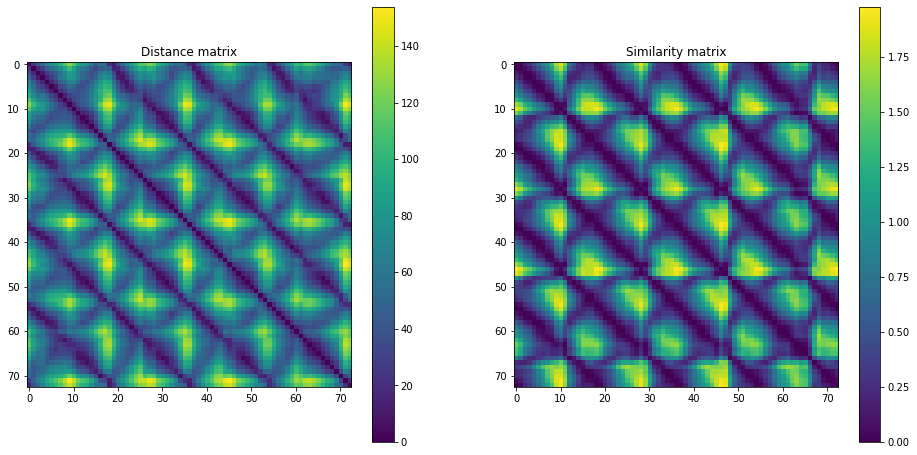

Batch 9/56 (ABL-5 LCA_30RAO) with 76 sequences


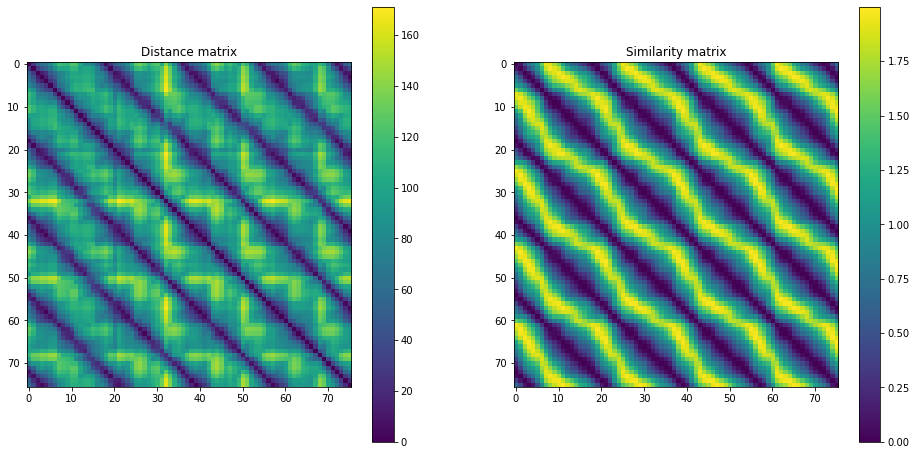

Batch 10/56 (ABL-5 LCA_AP) with 83 sequences


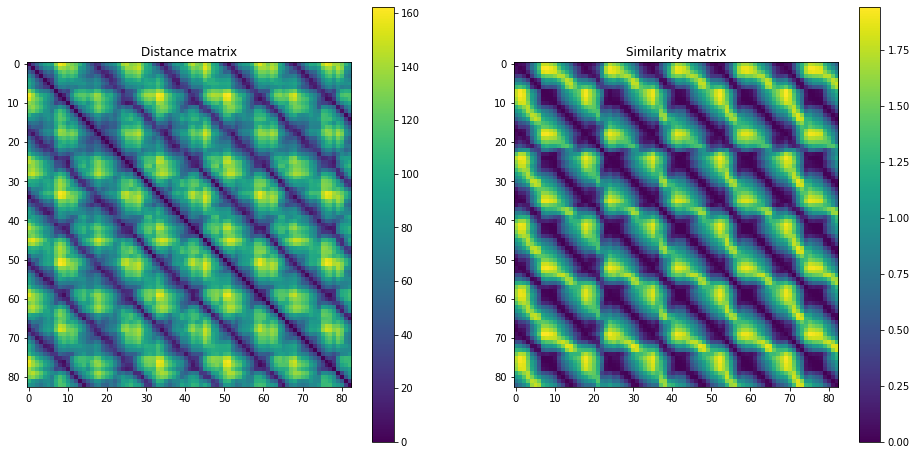

Batch 11/56 (ABL-5 LCA_LAT) with 83 sequences


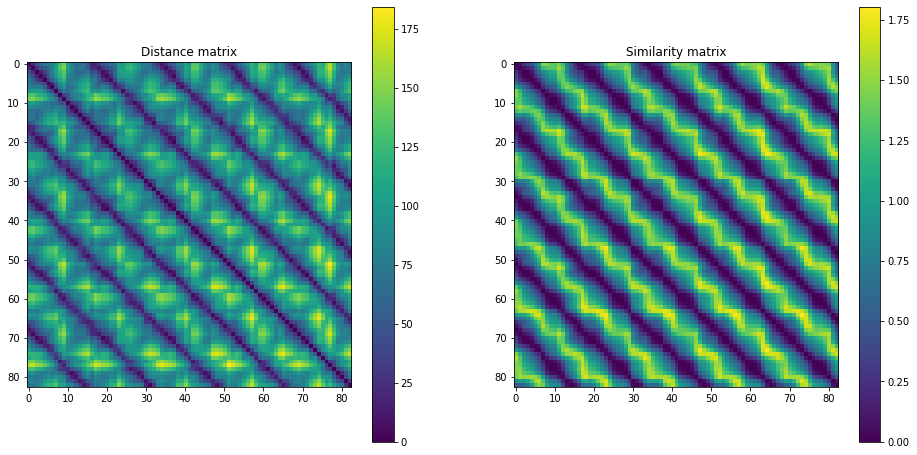

Batch 12/56 (ABL-5 RCA_AP) with 37 sequences


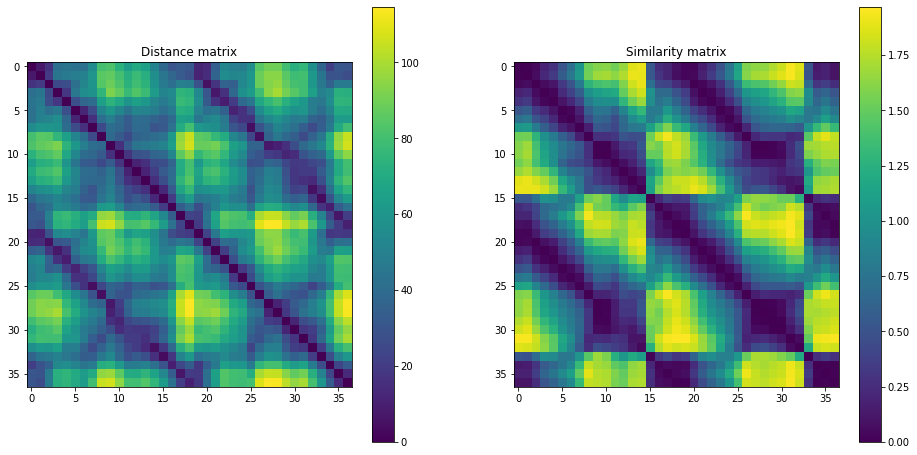

Batch 13/56 (ABL-5 RCA_LAT) with 37 sequences


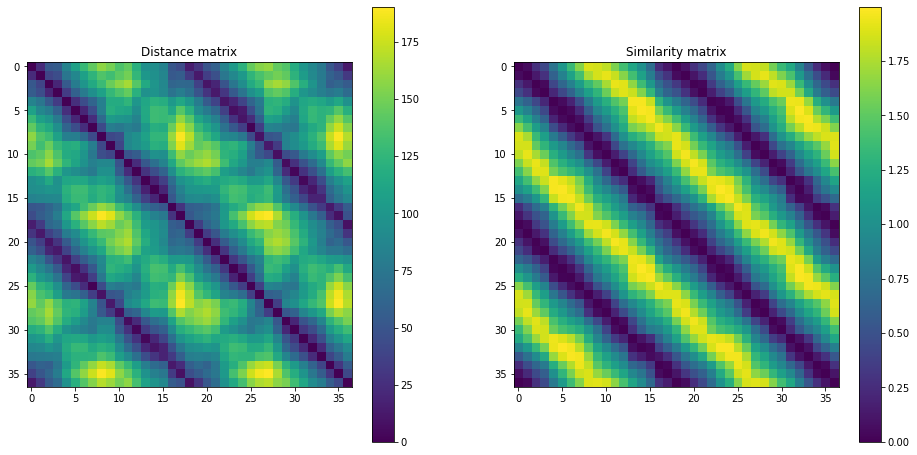

Batch 14/56 (AC-1 LCA_40RA015CAU) with 46 sequences


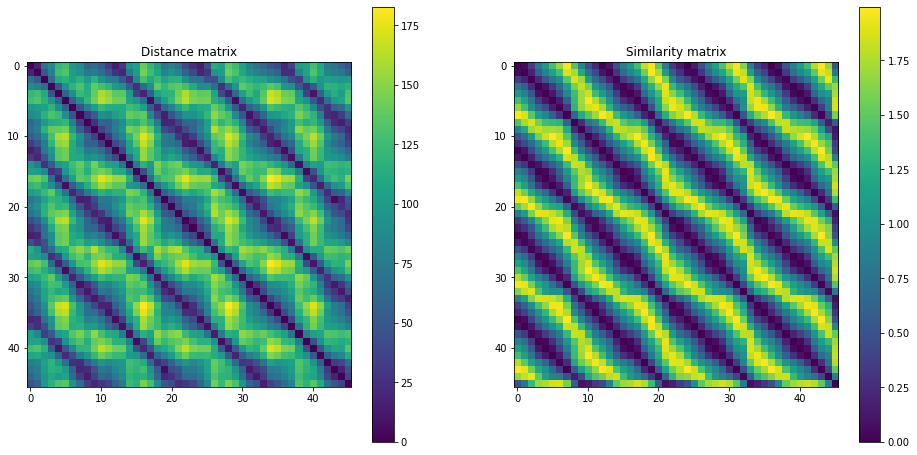

Batch 15/56 (AC-1 LCA_45LAO) with 42 sequences


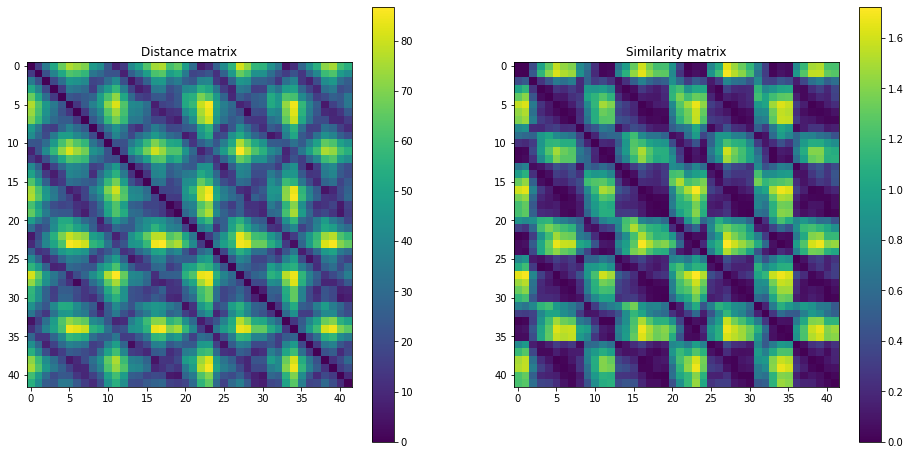

Batch 16/56 (AC-1 LCA_AP) with 47 sequences


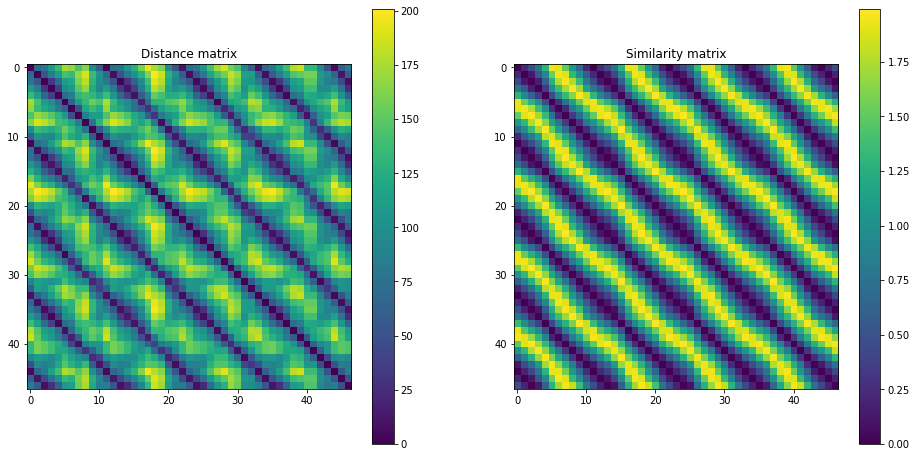

Batch 17/56 (AC-1 LCA_LAT) with 49 sequences


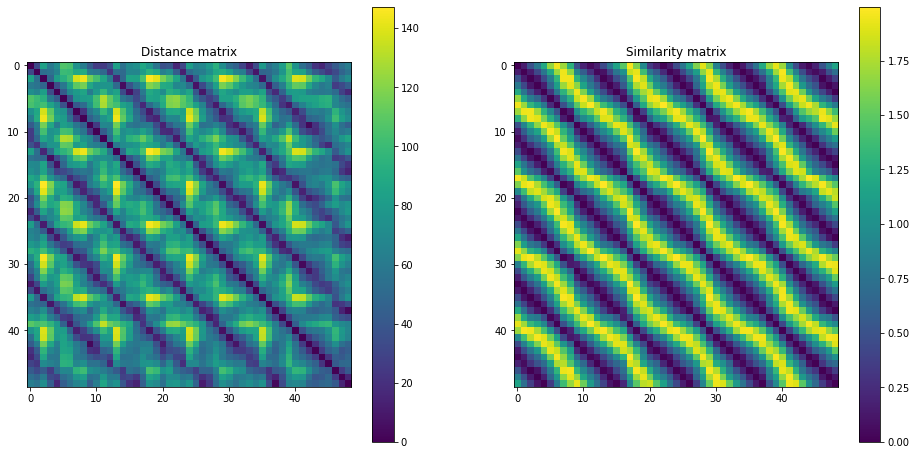

Batch 18/56 (AC-1 RCA_AP) with 52 sequences


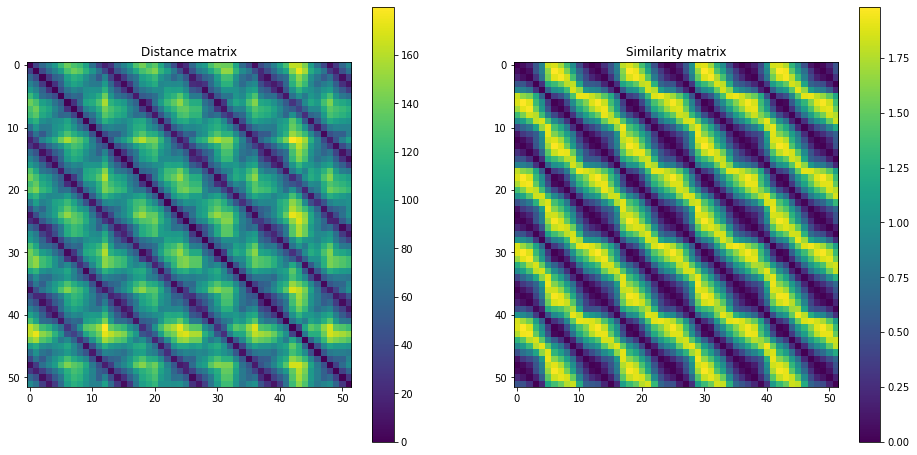

Batch 19/56 (AC-1 RCA_LAT) with 58 sequences


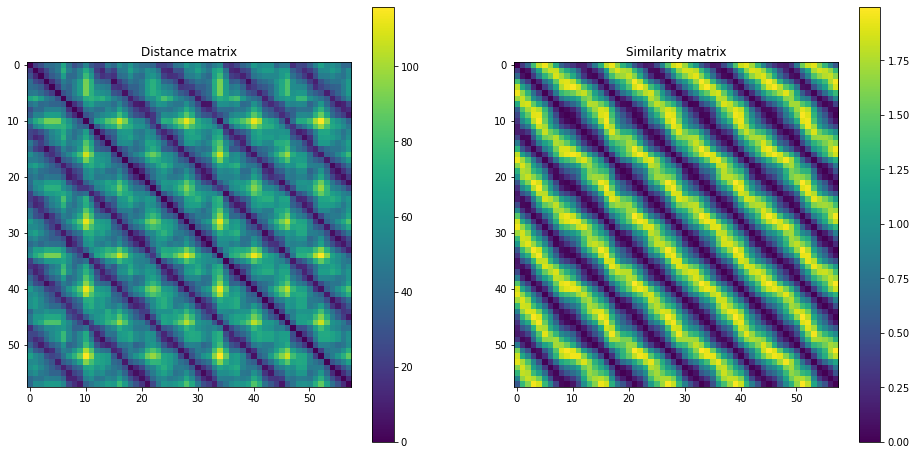

Batch 20/56 (ALR-2 LCA_30LAO25CRA) with 49 sequences


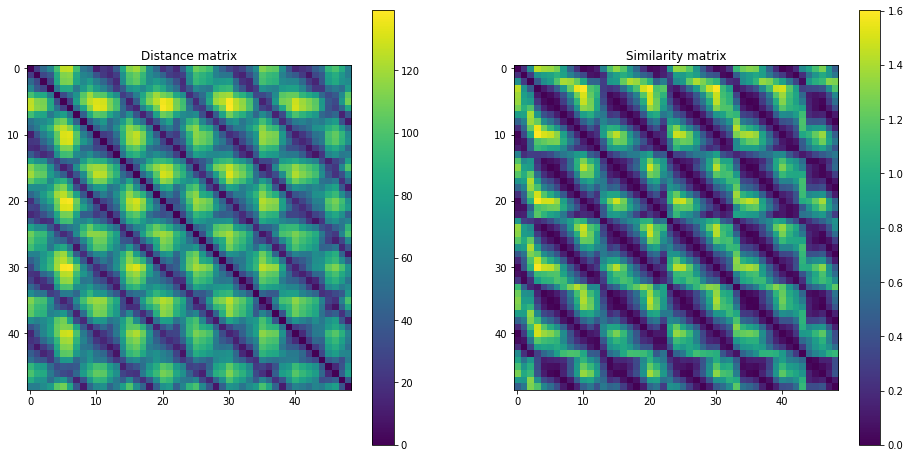

Batch 21/56 (ALR-2 LCA_30RAO) with 44 sequences


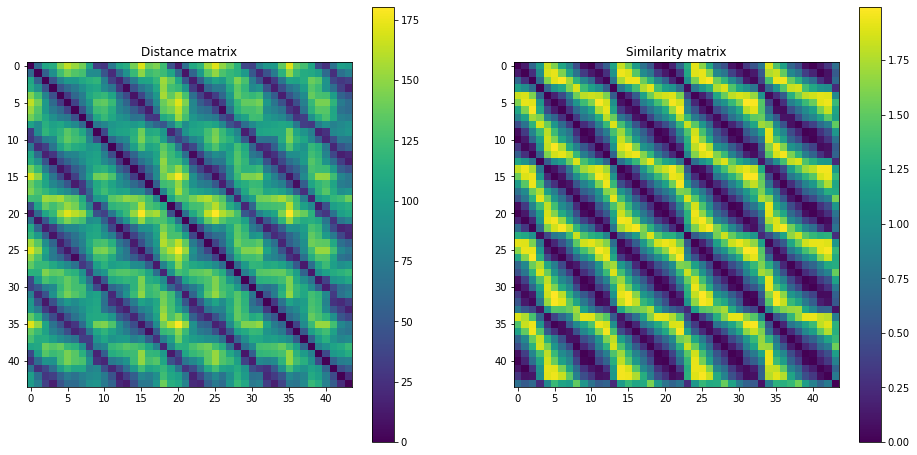

Batch 22/56 (ALR-2 LCA_AP) with 46 sequences


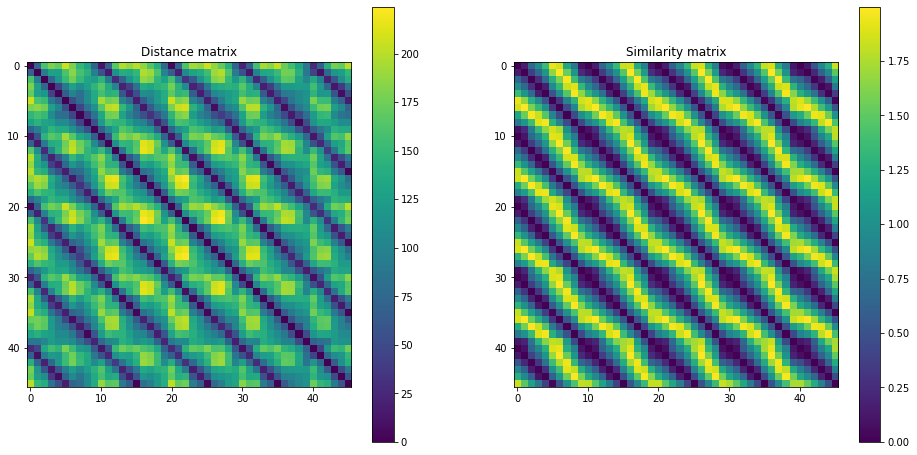

Batch 23/56 (ALR-2 LCA_LAT) with 47 sequences


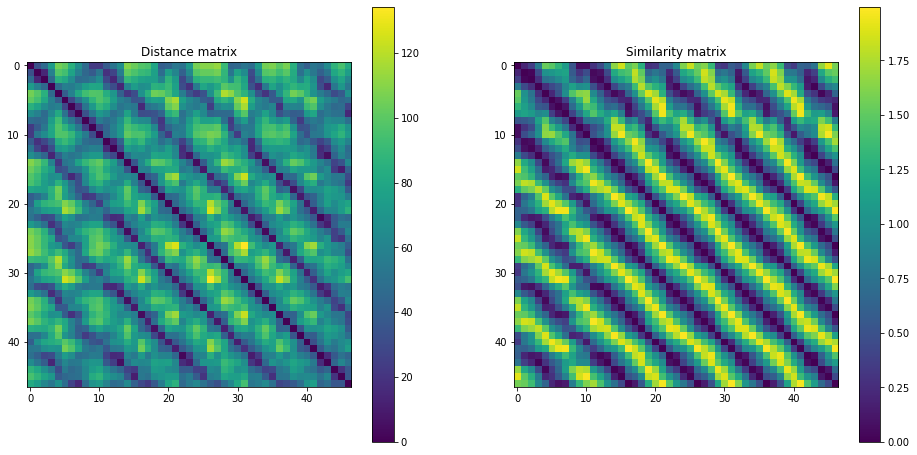

Batch 24/56 (ALR-2 RCA_AP) with 60 sequences


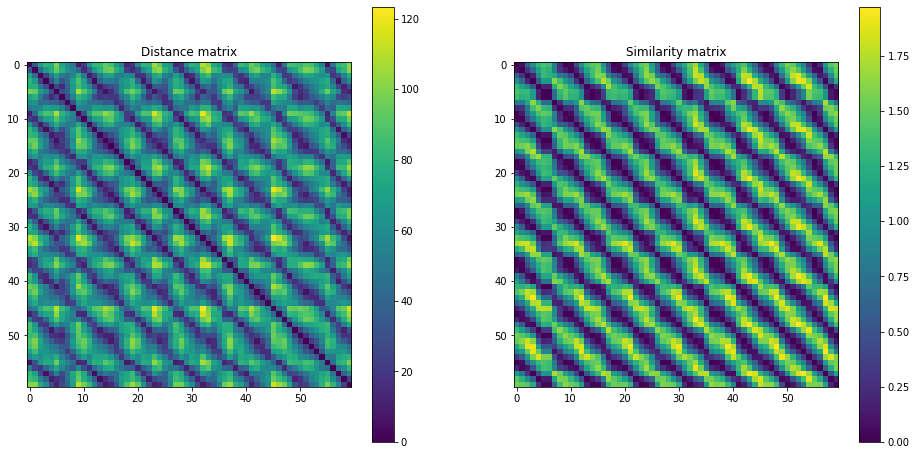

Batch 25/56 (JEL-10 LCA_30RA025CAU) with 51 sequences


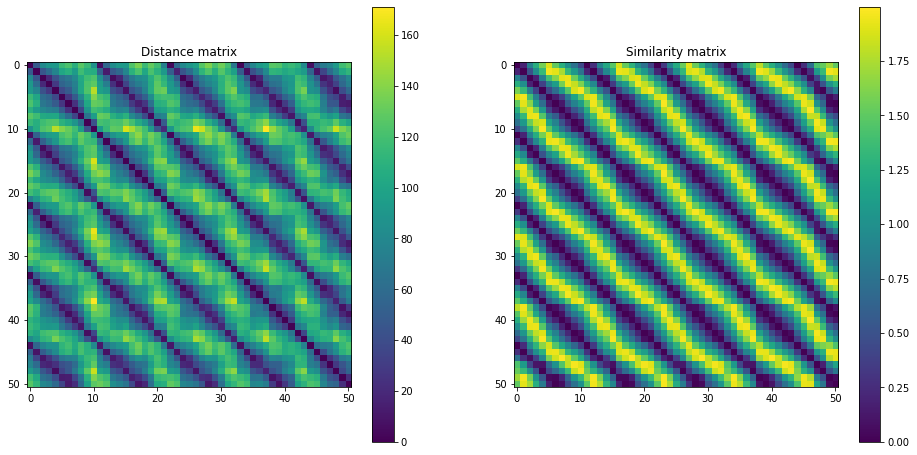

Batch 26/56 (JEL-10 LCA_30RAO) with 43 sequences


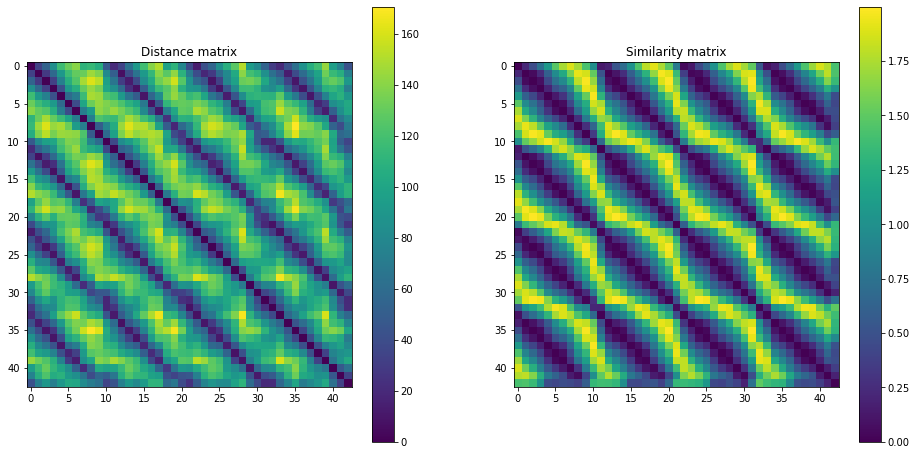

Batch 27/56 (JEL-10 LCA_AP) with 29 sequences


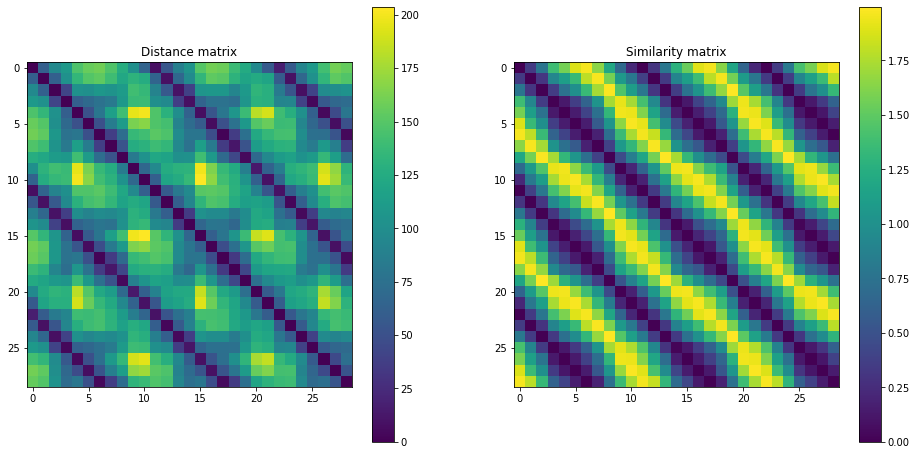

Batch 28/56 (JEL-10 LCA_LAT) with 68 sequences


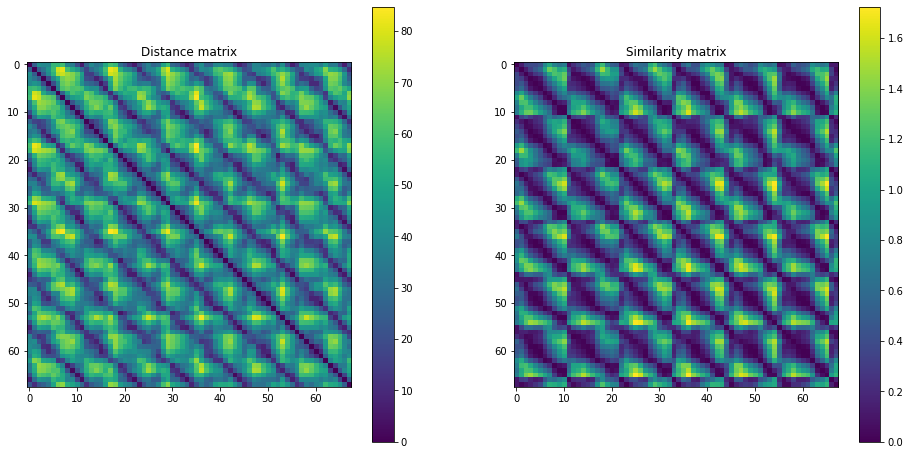

Batch 29/56 (JEL-10 RCA_AP) with 63 sequences


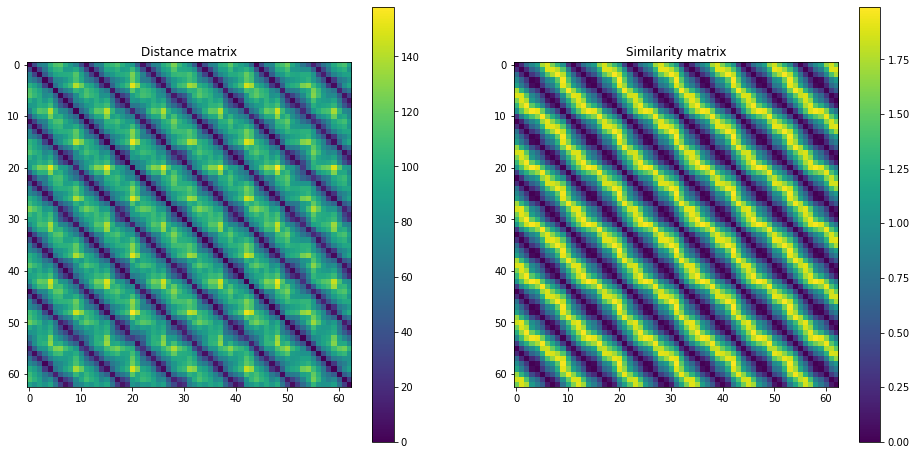

Batch 30/56 (JEL-10 RCA_LAT) with 42 sequences


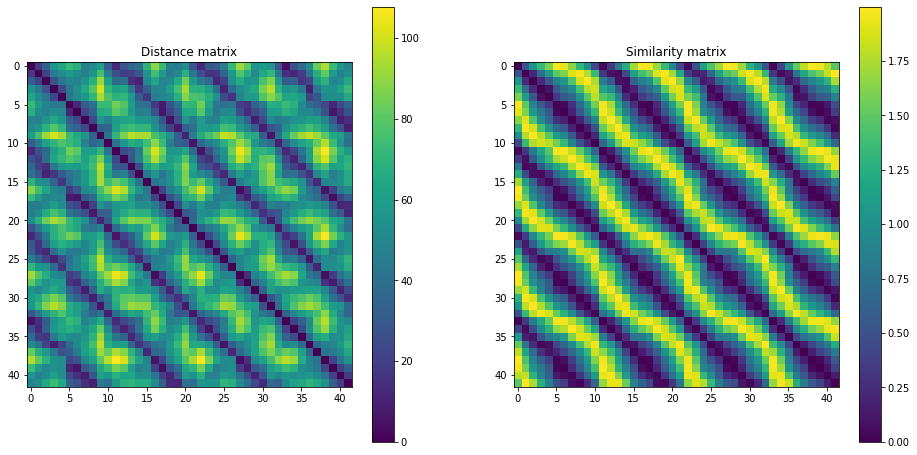

Batch 31/56 (KC-3 LCA_30RAO) with 82 sequences


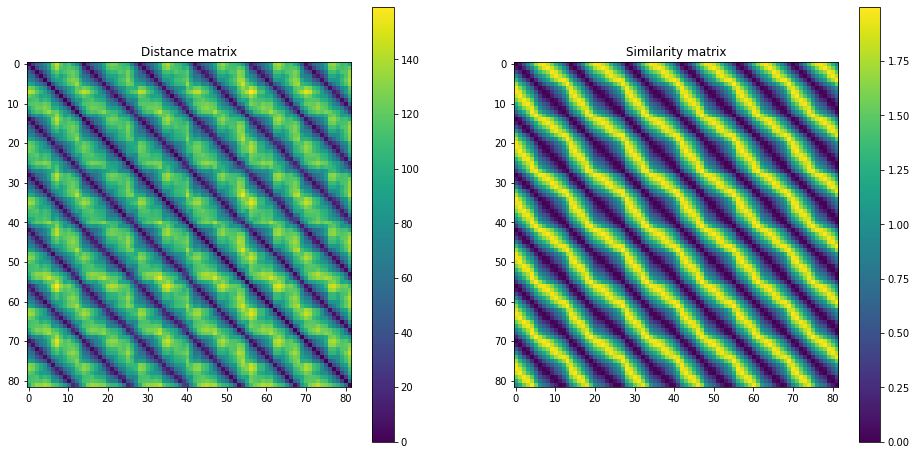

Batch 32/56 (KC-3 LCA_30RAO25CAU) with 97 sequences


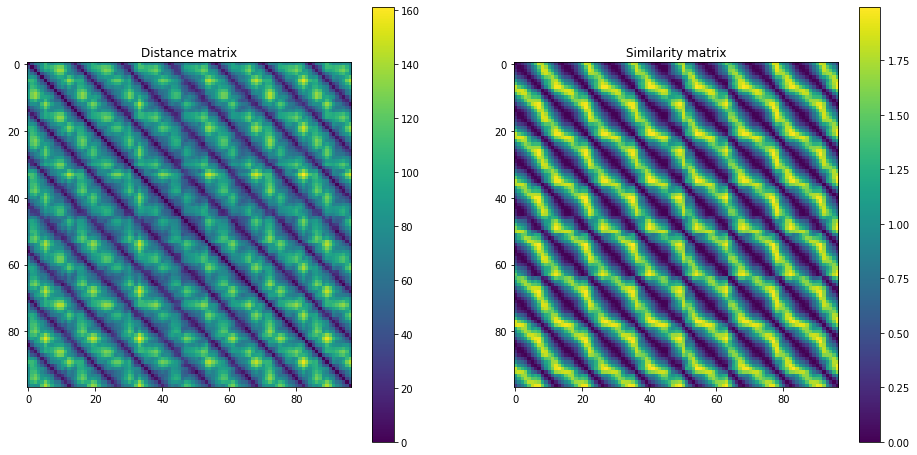

Batch 33/56 (KC-3 LCA_AP) with 80 sequences


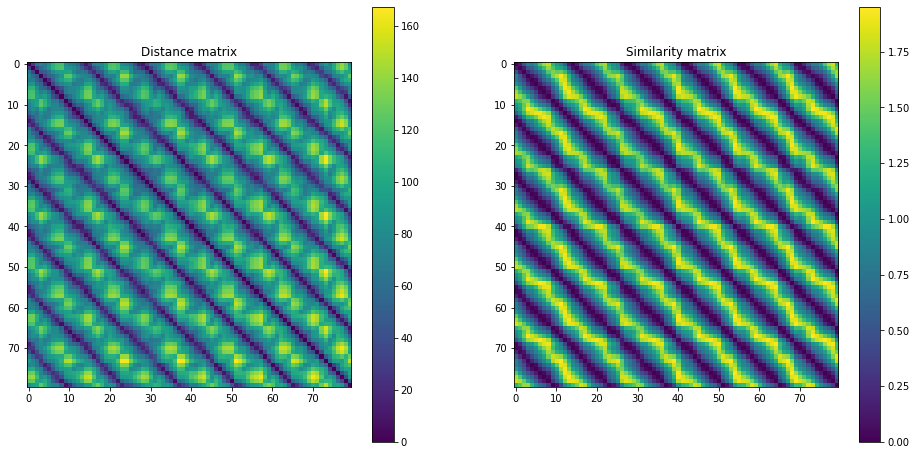

Batch 34/56 (KC-3 LCA_LAT) with 73 sequences


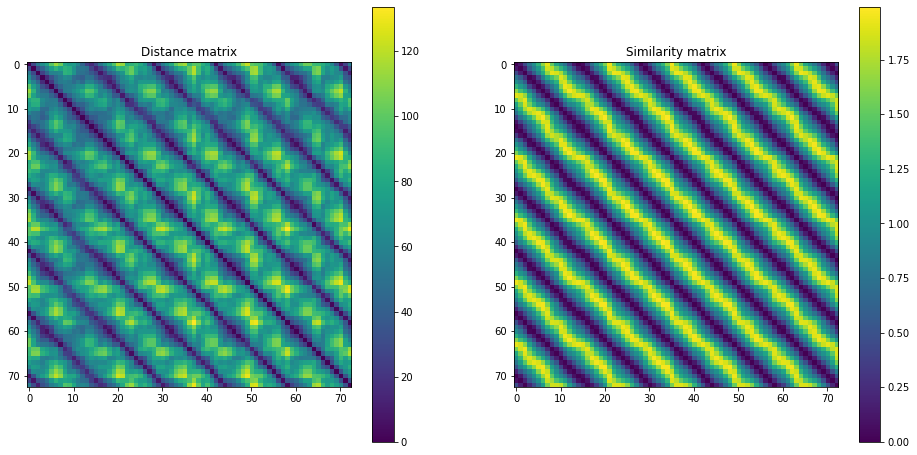

Batch 35/56 (KC-3 RCA_AP) with 92 sequences


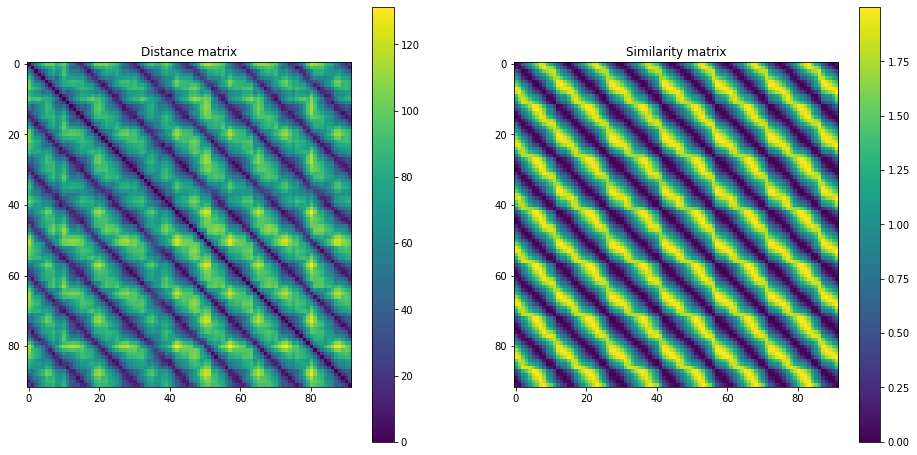

Batch 36/56 (KC-3 RCA_LAT) with 105 sequences


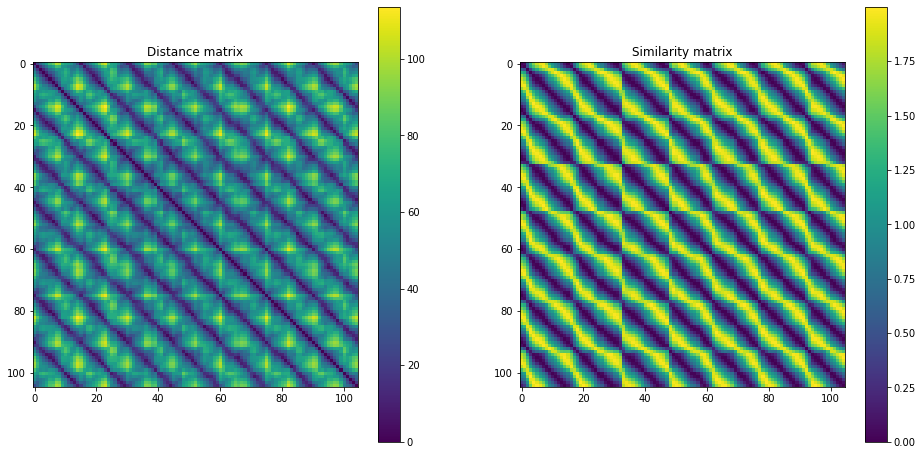

Batch 37/56 (KR-11 LCA_30LAO25CAU) with 37 sequences


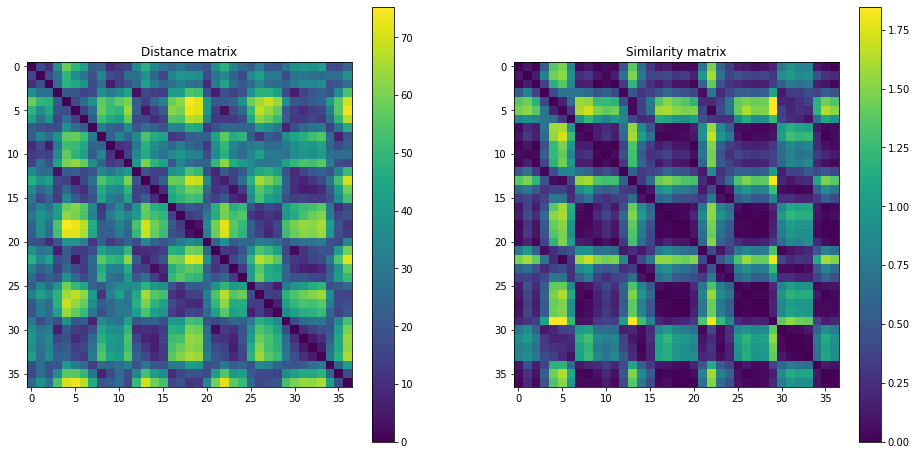

Batch 38/56 (KR-11 LCA_30LAO25CRA) with 40 sequences


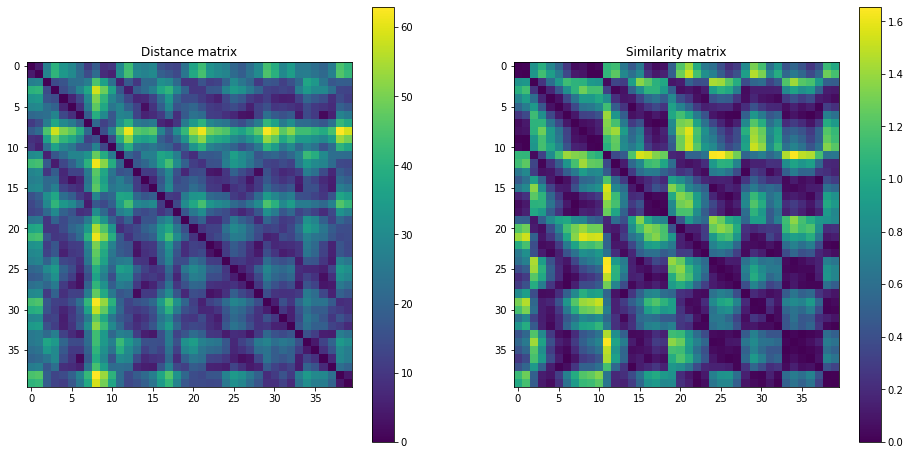

Batch 39/56 (KR-11 LCA_30RAO) with 39 sequences


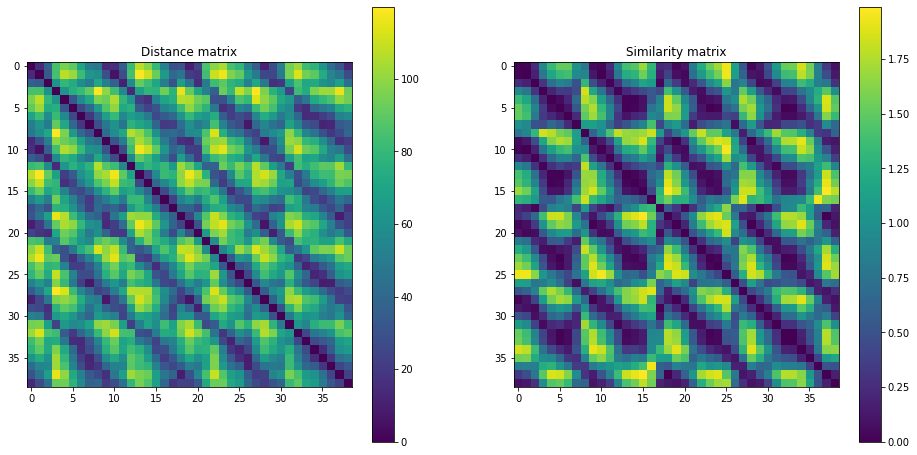

Batch 40/56 (KR-11 LCA_AP) with 48 sequences


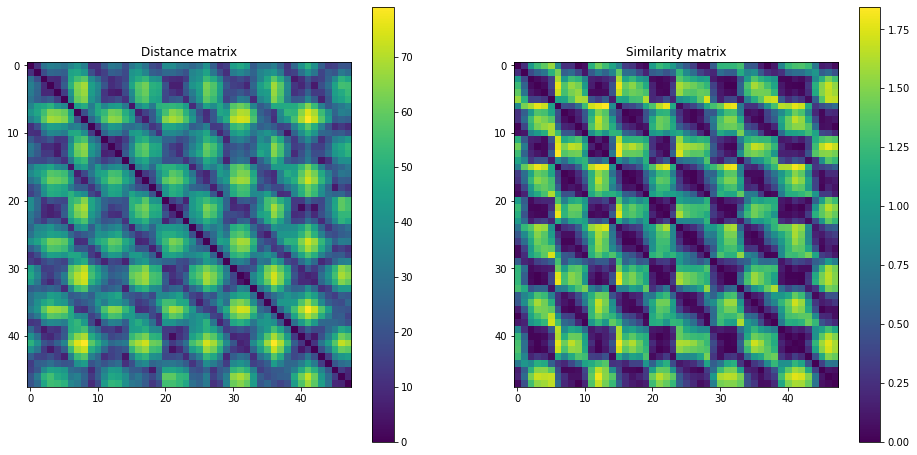

Batch 41/56 (KR-11 LCA_LAT) with 43 sequences


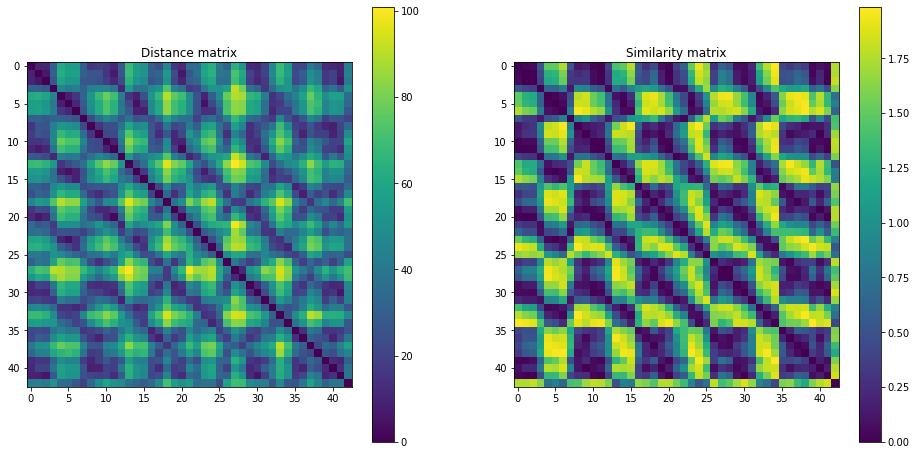

Batch 42/56 (KR-11 RCA_AP) with 61 sequences


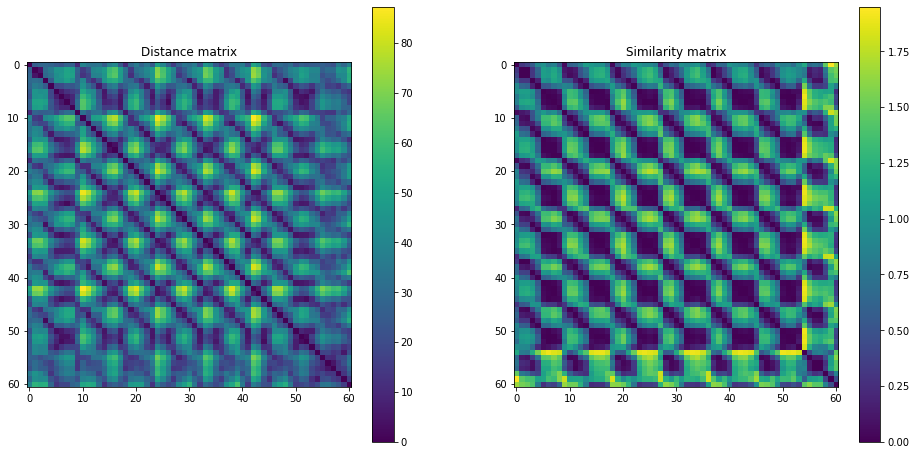

Batch 43/56 (KR-11 RCA_LAT) with 74 sequences


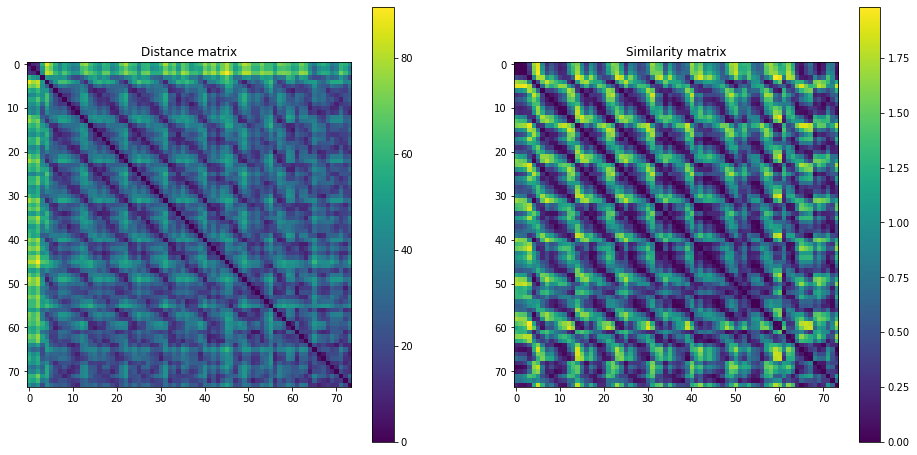

Batch 44/56 (MAL-8 LCA_AP) with 48 sequences


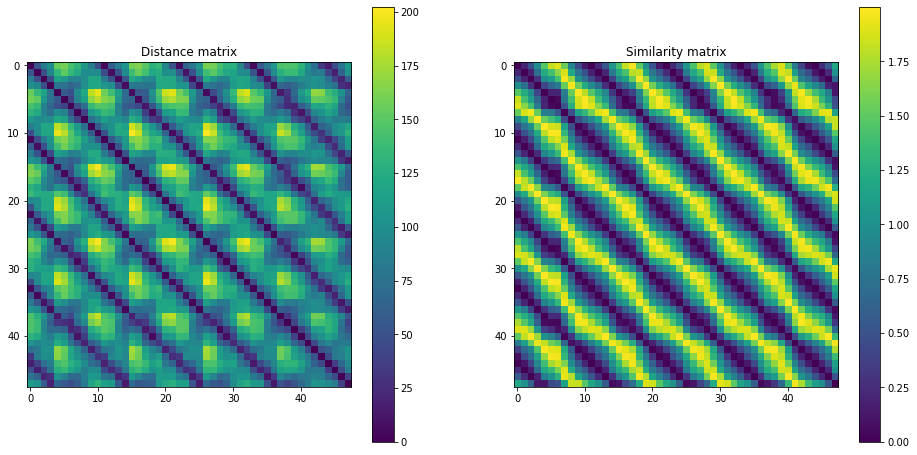

Batch 45/56 (MAL-8 LCA_LAT) with 45 sequences


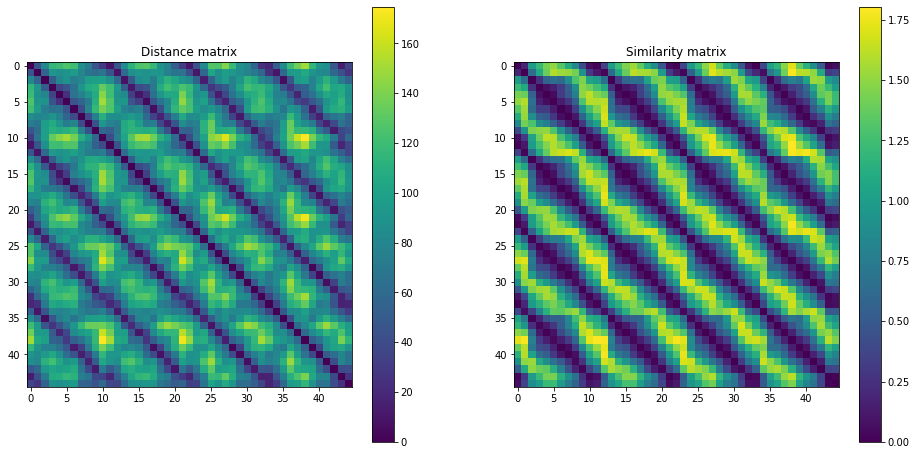

Batch 46/56 (MAL-8 RCA_AP) with 39 sequences


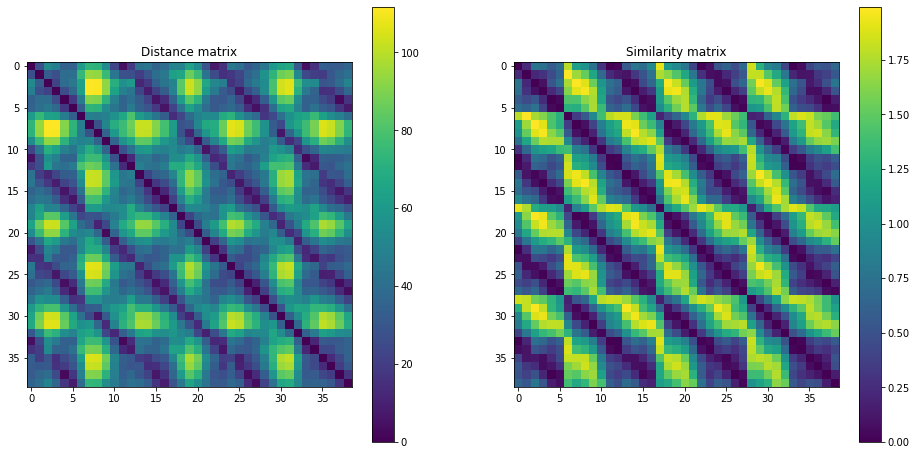

Batch 47/56 (MAL-8 RCA_LAT) with 39 sequences


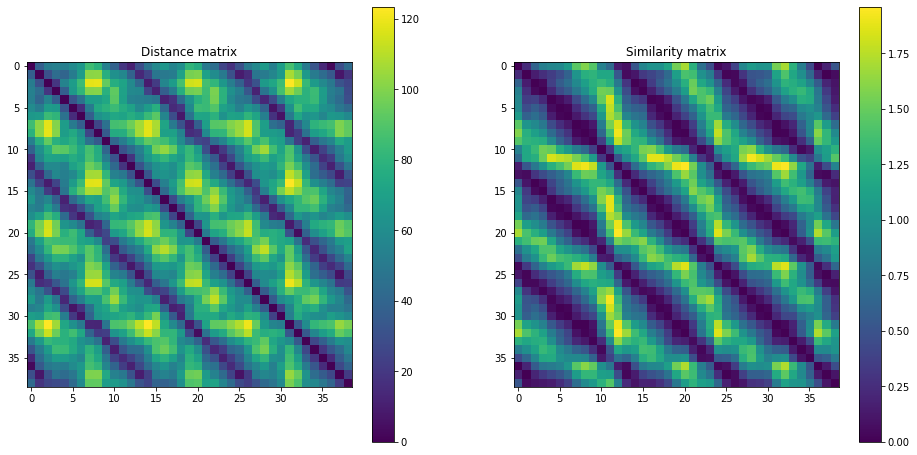

Batch 48/56 (MB-12 LCA_30LAO25CRA) with 50 sequences


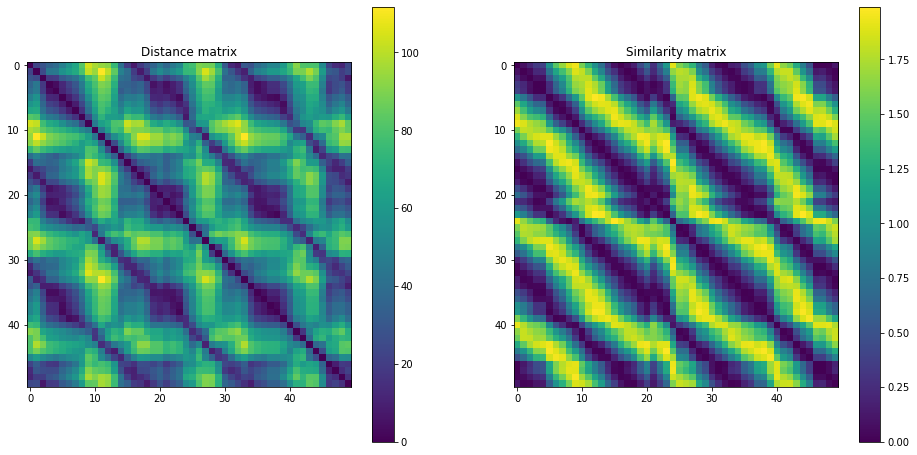

Batch 49/56 (MB-12 LCA_30RAO) with 53 sequences


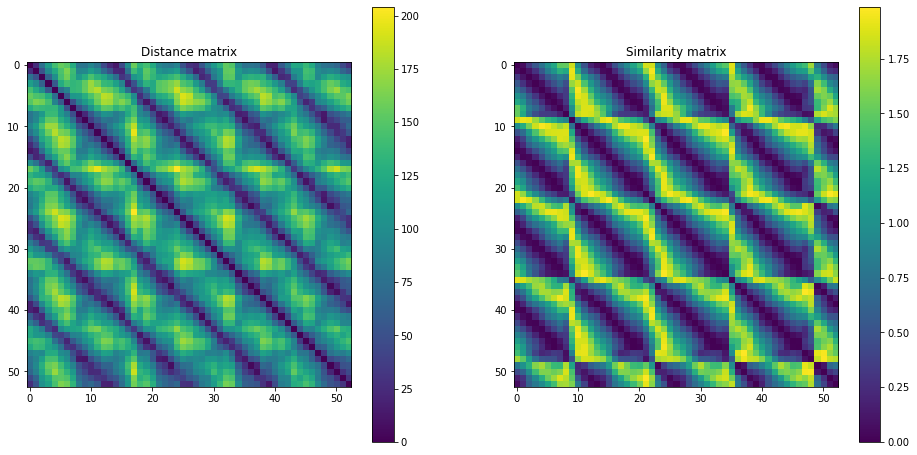

Batch 50/56 (MB-12 LCA_30RAO25CAU) with 49 sequences


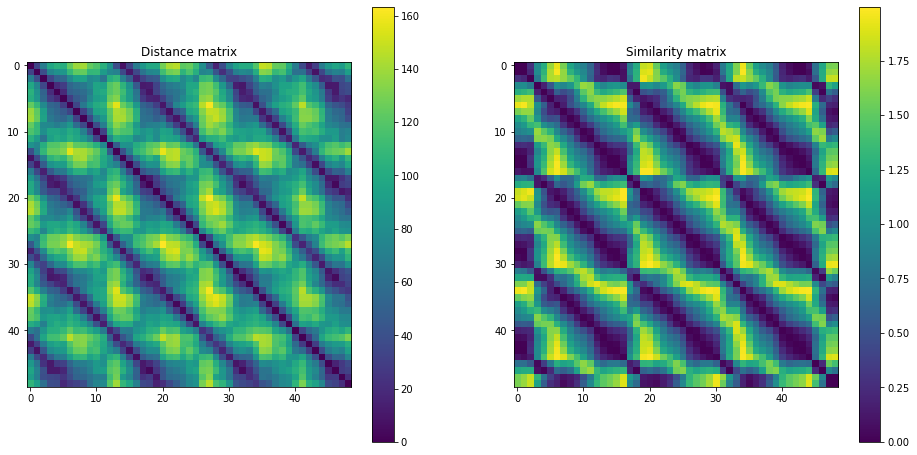

Batch 51/56 (MB-12 LCA_AP) with 49 sequences


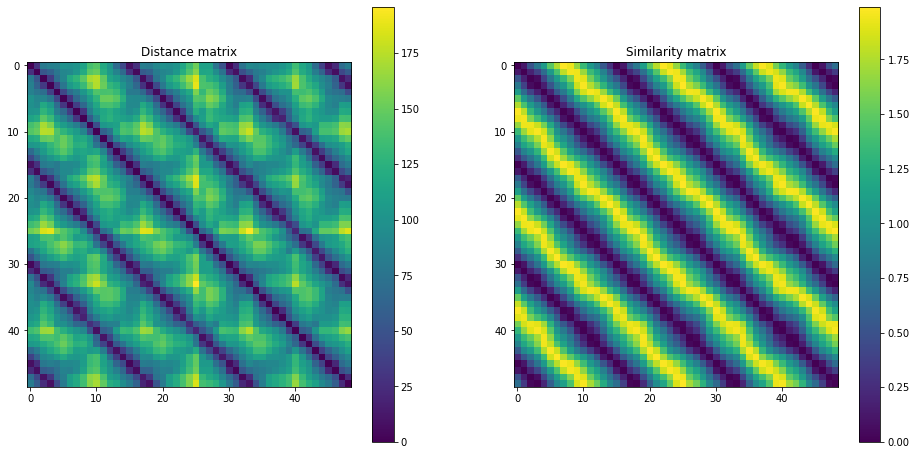

Batch 52/56 (MB-12 LCA_LAT) with 50 sequences


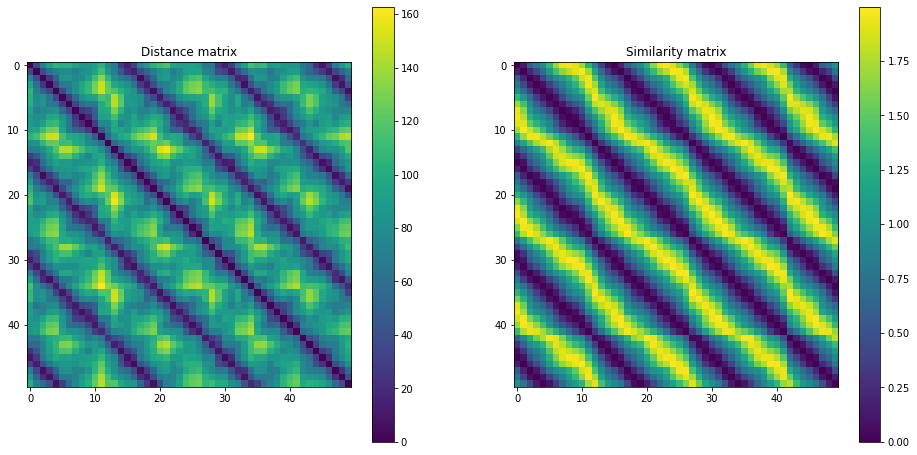

Batch 53/56 (MJY-9 RCA_AP) with 44 sequences


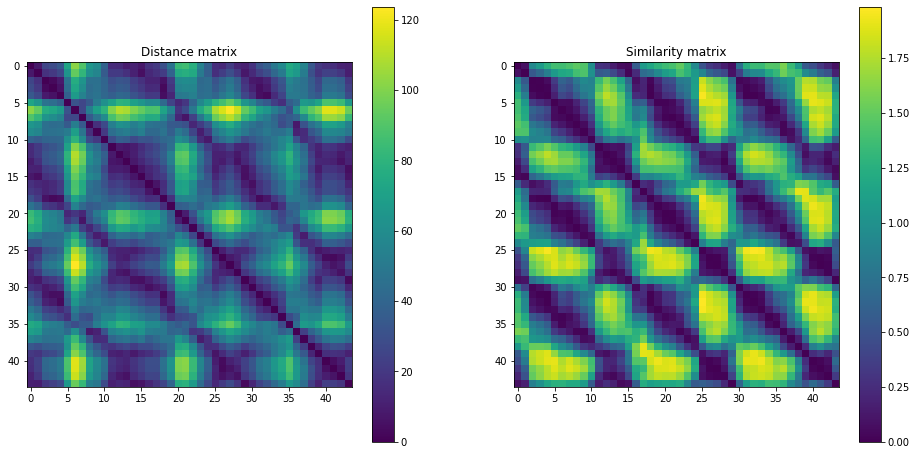

Batch 54/56 (MJY-9 RCA_LAT) with 50 sequences


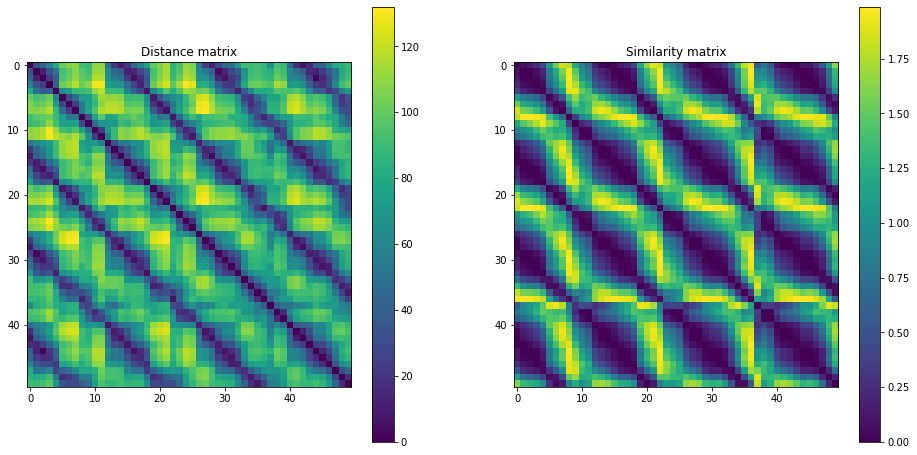

Batch 55/56 (SB-6 RCA_AP) with 41 sequences


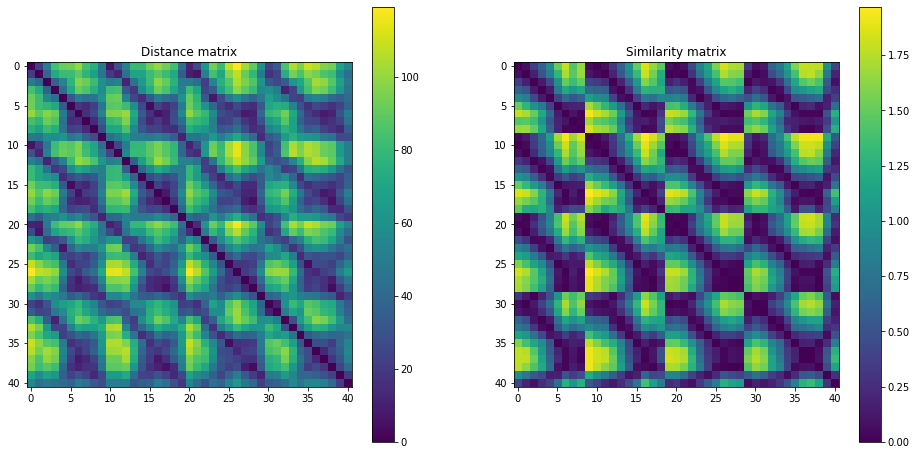

Batch 56/56 (SB-6 RCA_LAT) with 39 sequences


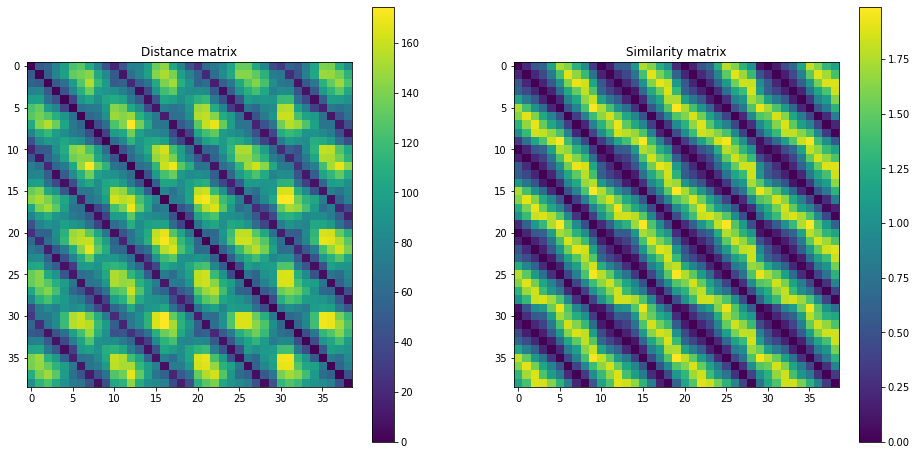

Combinations of AA-4
Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_30RAO


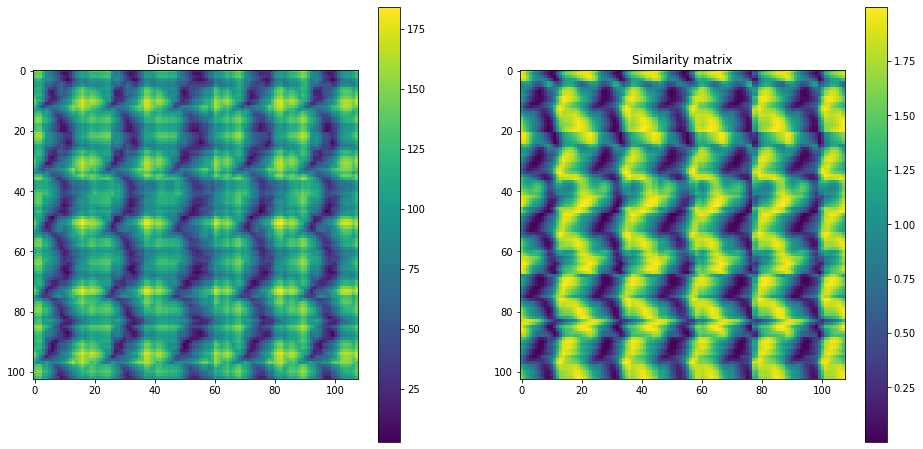

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_30RAO25CAU


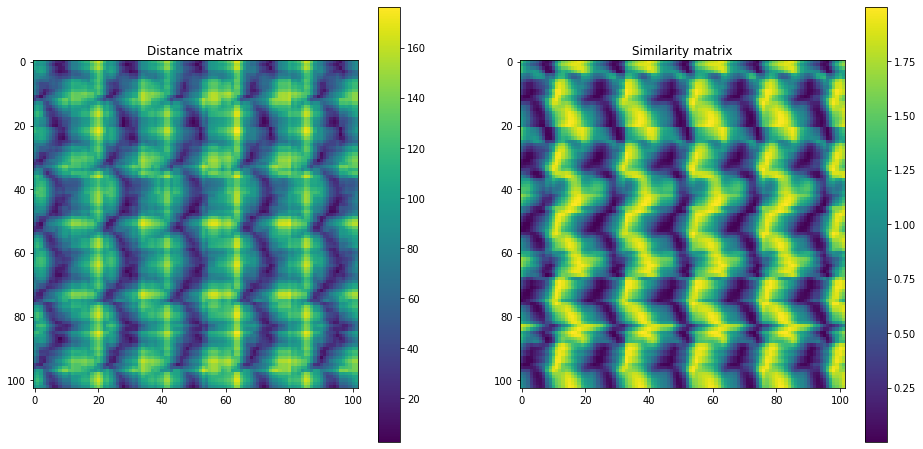

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_AP


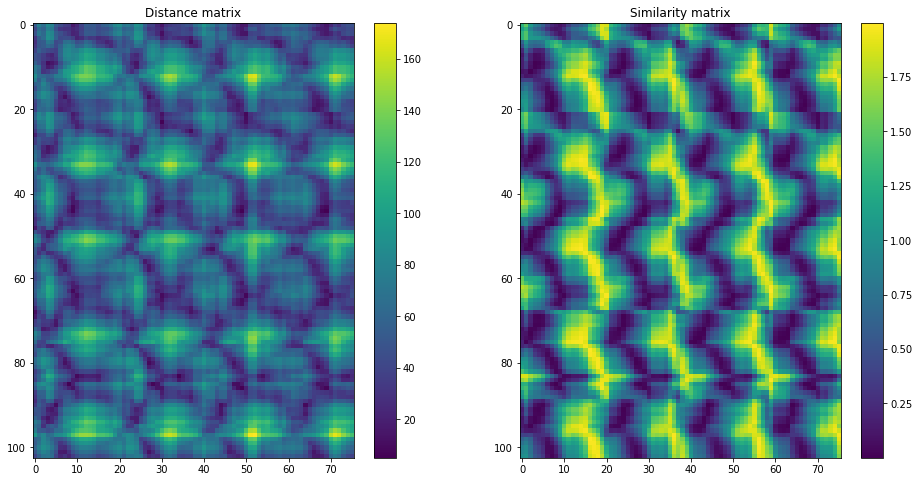

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_LAT


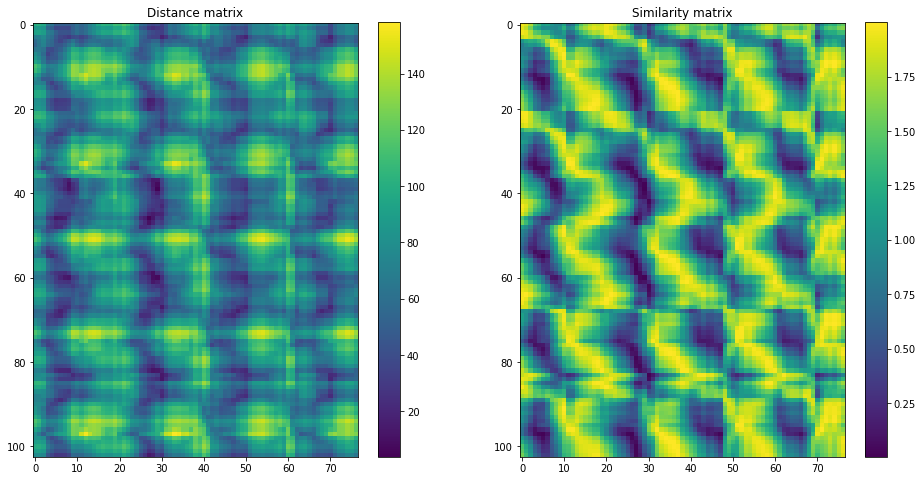

Comparison of AA-4 LCA_30LAO25CAU and AA-4 RCA_AP


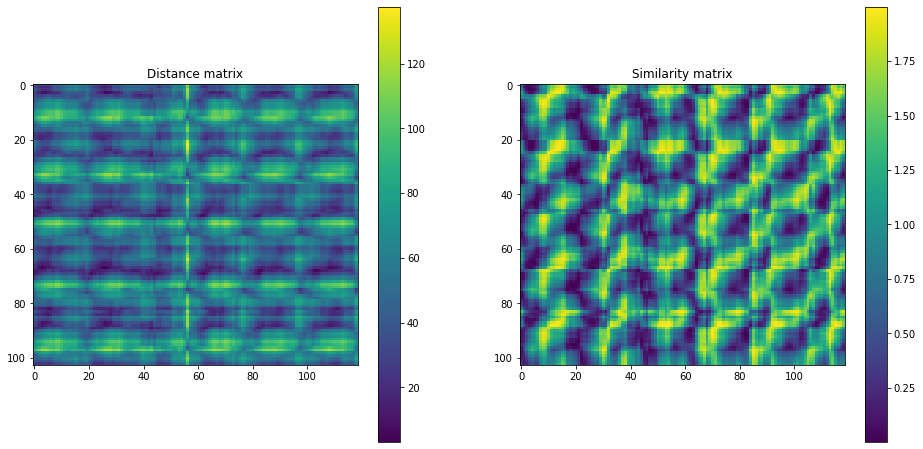

Comparison of AA-4 LCA_30LAO25CAU and AA-4 RCA_LAT


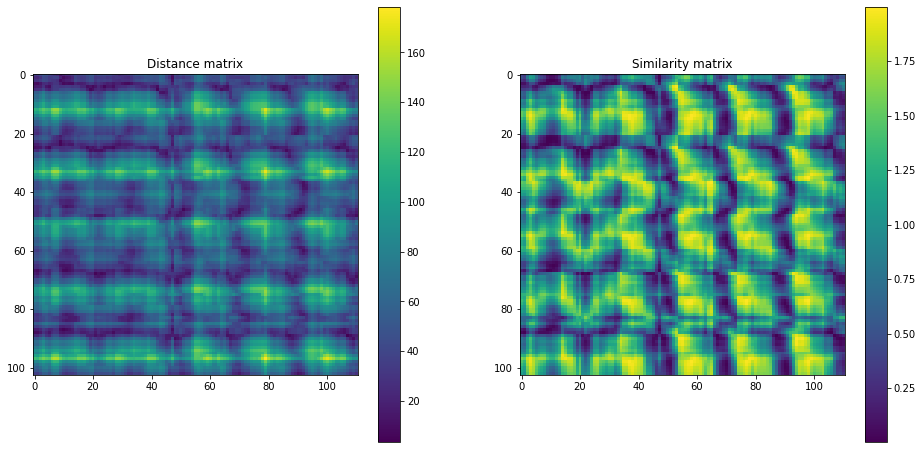

Combinations of AA-4
Comparison of AA-4 LCA_30RAO and AA-4 LCA_30RAO25CAU


KeyboardInterrupt: 

In [4]:
def calc_distance_and_similarity_matrices(embeddings):
    distances = []
    similarities = []
    for i in range(len(embeddings)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
                similarities_i.append(similarities[j][i])
            elif j == i:
                distances_i.append(0)
                similarities_i.append(0)
            else:
                # Distance
                dist_val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(dist_val.cpu().numpy())
                # Similarity
                normalized_embedding_i = embeddings[i] / torch.norm(embeddings[i])
                normalized_embedding_j = embeddings[j] / torch.norm(embeddings[j])
                sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
                similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

def calc_distance_and_similarity_matrices2(embeddings1, embeddings2):
    distances = []
    similarities = []
    for i in range(len(embeddings1)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings2)):
            # Distance
            dist_val = torch.sum(torch.abs(embeddings1[i] - embeddings2[j]))
            distances_i.append(dist_val.cpu().numpy())
            # Similarity
            normalized_embedding_i = embeddings1[i] / torch.norm(embeddings1[i])
            normalized_embedding_j = embeddings2[j] / torch.norm(embeddings2[j])
            sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
            similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    all_embeddings = []
    names = []
    for batch_index, sequences in enumerate(test_loader):
        name = sequences[1][0]
        sequences = sequences[0]
        
        # sequences: (batch, video_frame, channel, width, height)
        embeddings = []
        print (f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
        embeddings = model(sequences[0])
        all_embeddings.append(embeddings)
        names.append(name)
        
        distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices(embeddings)
        
        figure(figsize=(16,8))
        
        plt.subplot(1, 2, 1)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix")
        
        plt.subplot(1, 2, 2)
        plt.imshow(similarity_matrix)
        plt.colorbar()
        plt.title(f"Similarity matrix")
        
        plt.show()
    
    current_name = None
    for i in range(len(all_embeddings)):
        name_i = names[i].split(' ')[0]
        if not name_i == current_name:
            print(f"Combinations of {name_i}")
        for j in range(i+1, len(all_embeddings)):
            if name_i == names[j].split(' ')[0]:
                print(f"Comparison of {names[i]} and {names[j]}")
                distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices2(all_embeddings[i], all_embeddings[j])

                figure(figsize=(16,8))

                plt.subplot(1, 2, 1)
                plt.imshow(distance_matrix)
                plt.colorbar()
                plt.title(f"Distance matrix")

                plt.subplot(1, 2, 2)
                plt.imshow(similarity_matrix)
                plt.colorbar()
                plt.title(f"Similarity matrix")

                plt.show()